# Prediciting high school graduation rate of a cohort based on holistic data of the student population and school.

What do variables about:
- the broader structure of a school
- the experience of previous cohorts
- the freshmen, sophomore and junior year experience of rising seniors
tell us about the graduating % of rising seniors?

Data was gathered from https://www.isbe.net/pages/illinois-state-report-card-data.aspx
I have collected end of year data for the following academic years:
- 2018/19
- 2017/18
- 2016/17
- 2015/16
- 2014/15
- 2013/14
- 2012/13

I will look at the following cohorts for training the data:

- Class of 2017
- Class of 2016

and follow them thru their 4 years of high school (grades 9-12)

I will run validation on 
- Class of 2018

My test set with be 
- Class of 2019

The goal is to predict the 4-year high school graduation rate for this cohort.

# Cleaning and exploring datasets for capstone project

Gathering the data for each of the academic years 2013 - 2017 involved downloading semi-colon separated .txt files, importing them into a spreadsheet, then matching the columns to headers that were recorded in a separate .xls file. While performing this task, I also selected feature set to use for this project.

I also added a column to every academic year to identify the cohort by their graduation year (e.g. 2018). 

I will create a matrix of the information for each cohort.

In [2]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

# import additional libraries
import pandasql as ps
from pandasql import sqldf

import statsmodels.api as sm
from statsmodels.formula.api import ols

# pysqldf lambda function
pysqldf = lambda q: sqldf(q, globals())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# eda function
def proj_eda(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)

In [4]:
def clean_col(df):

    df.columns = [x.lower()
                 .replace("-", " ")
                 .replace("  ", " ")
                 .replace(" ", "_")
                 .replace("__", "_")
                 .rstrip()
                 .replace("#", "number")
                 .replace("%", "percent") for x in df.columns]
    return df.columns.to_list()

In [91]:
# plot parameters
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16

In [6]:
# histogram function



In [7]:
# heatmap function
def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(10, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='YlGnBu', 
                    cbar=False,
                    vmin=-1,
                    vmax=1)  
    return g

### Step 1
create a dataframe for each academic year for schools that serve grades 9 - 12.
This will include traditional high schools and some charter schools that serve grades in addition to 9 - 12. This may have an impact on features such as the total number of students in a school, attendance rate and I will have to be aware and make corrections if needed.

#### Class of 2019

In [8]:
df_19 = pd.read_excel('../../data/2019-Report-Card-Public-Data-Set.xlsx')
df_19.shape

(4738, 36)

In [9]:
clean_col(df_19)

['cohort',
 'rcdts',
 'type',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 '

In [10]:
# create query to return schools with grades 9-12

q1 = """SELECT * 
       FROM df_19
       WHERE grades_served LIKE "%12%";"""

hs_19 = pysqldf(q1)

In [11]:
hs_19.head()

,cohort,rcdts,type,school_name,district,city,county,district_type,district_size,school_type,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2019.0,010010010260001,School,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,86.8,2.0,68.8,68.8,95.6,NaN,NaN,NaN
1,2019.0,010010020260001,School,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,83.9,2.0,58.1,58.1,94.0,NaN,NaN,NaN
2,2019.0,010010030260001,School,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,83.3,2.0,75.0,73.3,94.9,NaN,NaN,NaN
3,2019.0,010010040260001,School,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,86.4,1.0,60.7,60.7,92.9,NaN,NaN,27.0
4,2019.0,010011720220003,School,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,...,None,None,86.4,2.0,67.7,65.7,74.9,68.0,127.0,126.0


In [104]:
hs_19.high_school_4_year_graduation_rate_total.describe()

count    714.000000
mean      84.853782
std       13.925557
min       15.400000
25%       81.800000
50%       88.900000
75%       93.475000
max      100.000000
Name: high_school_4_year_graduation_rate_total, dtype: float64

In [105]:
merged_df.high_school_4_year_graduation_rate_total.describe()

count    3384.000000
mean       85.282990
std        13.163676
min         0.000000
25%        81.599998
50%        88.500000
75%        93.300003
max       100.000000
Name: high_school_4_year_graduation_rate_total, dtype: float64

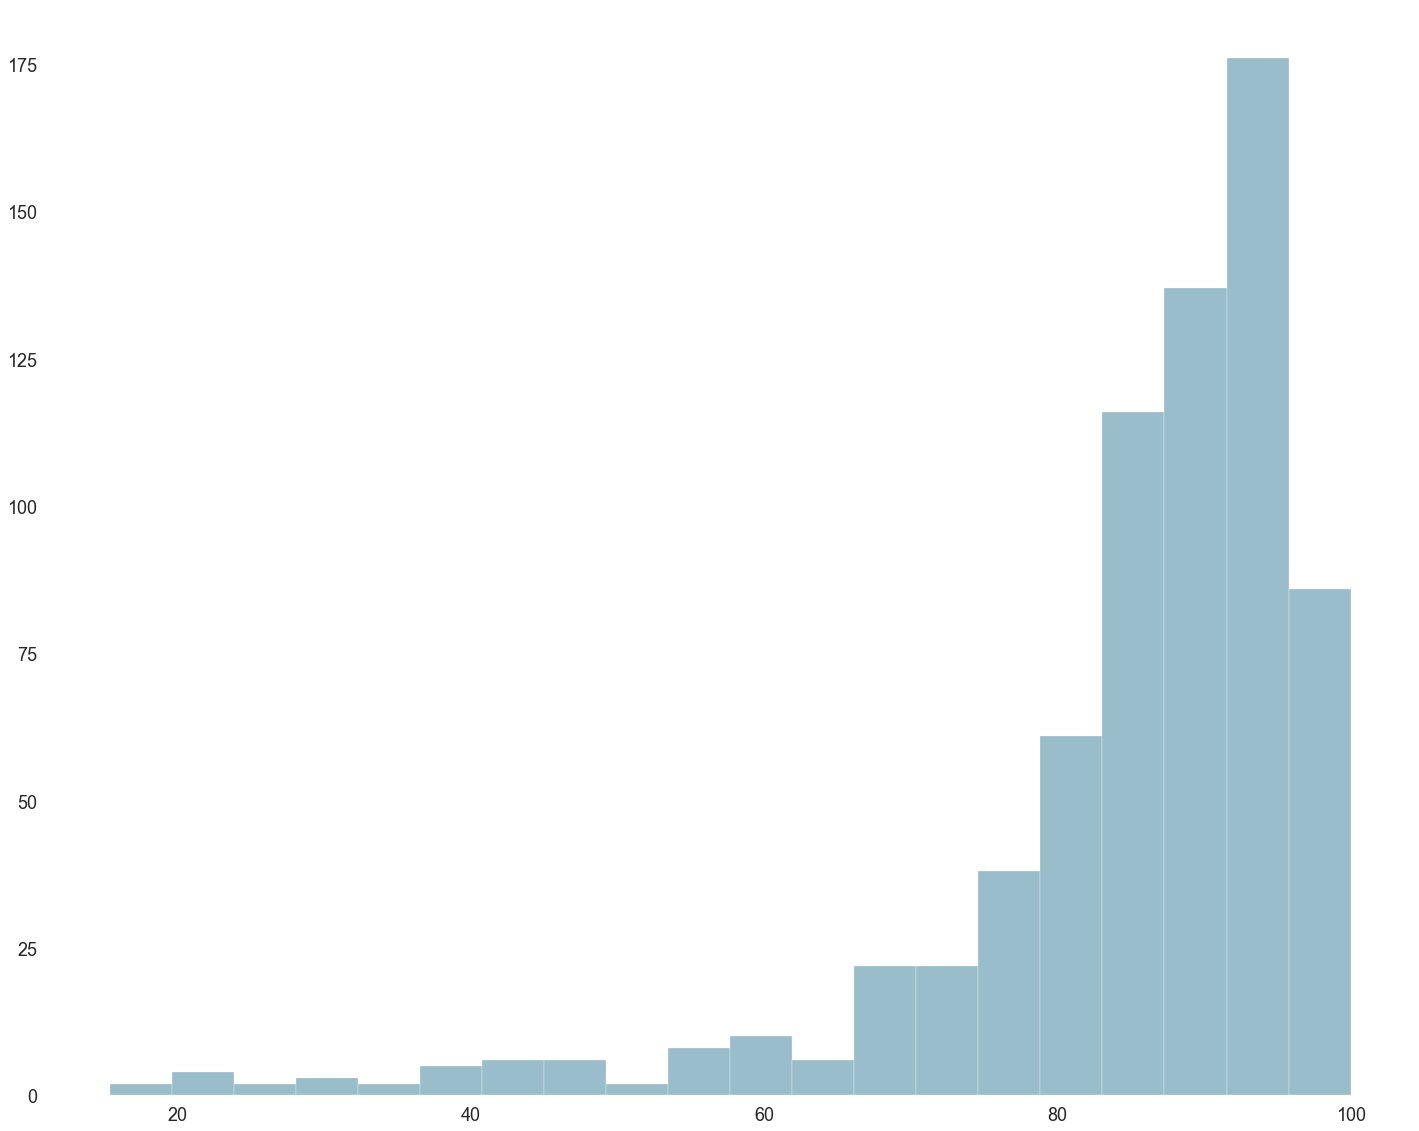

In [101]:

# plot parameters
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16

fig = plt.subplots(figsize=(20,16))
plt.hist(hs_19.high_school_4_year_graduation_rate_total, bins = 20, color='#99BDCB')
#plt.title('HS 4 year graduation rate 2019')
#plt.xlabel('Count of Schools')
#plt.ylabel('Graduation Rate')
plt.tight_layout()
plt.savefig('figures/2019_hist.png')
plt.show();

#### Class of 2018

In [13]:
df_18 = pd.read_excel('../../data/2018-Report-Card-Public-Data-Set.xlsx', sheet_name="General")
df_18.shape

(4754, 36)

In [14]:
clean_col(df_18)

['cohort',
 'rcdts',
 'type',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 '

In [15]:
q2 = """SELECT * 
       FROM df_18
       WHERE grades_served LIKE "%12%";"""

hs_18 = pysqldf(q2)

In [16]:
hs_18.head()

,cohort,rcdts,type,school_name,district,city,county,district_type,district_size,school_type,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2018.0,010010010260001,School,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,90.6,2.0,81.5,81.5,100.0,NaN,NaN,NaN
1,2018.0,010010020260001,School,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,84.8,2.0,80.4,80.4,93.0,NaN,NaN,NaN
2,2018.0,010010030260001,School,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,83.7,1.0,75.0,75.0,94.0,NaN,NaN,NaN
3,2018.0,010010040260001,School,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,83.7,1.0,74.0,72.0,80.0,NaN,NaN,20.0
4,2018.0,010011720220003,School,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,...,None,None,81.9,3.0,68.9,68.2,51.0,109.0,110.0,148.0


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


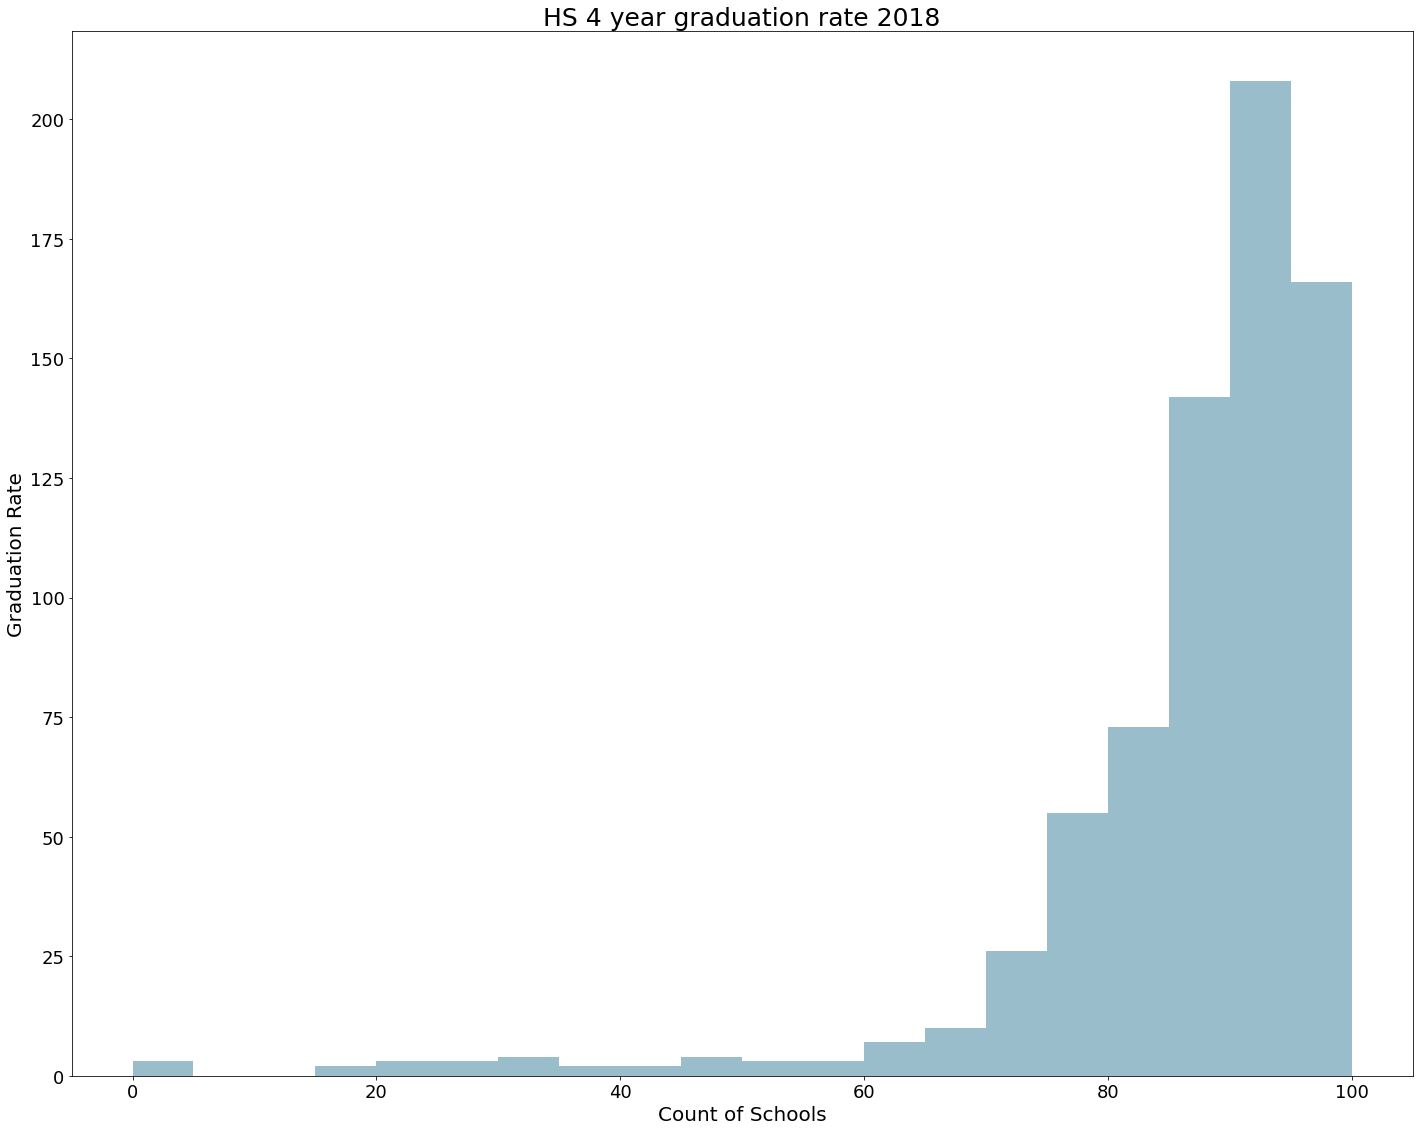

In [17]:
fig = plt.subplots(figsize=(20,16))
plt.hist(hs_18.high_school_4_year_graduation_rate_total, bins = 20, color='#99BDCB')
plt.title('HS 4 year graduation rate 2018')
plt.xlabel('Count of Schools')
plt.ylabel('Graduation Rate')
plt.tight_layout()
plt.savefig('figures/2018_hist.png')
plt.show();

In [18]:
def bar(x, y, title, xlabel):
    fig = plt.subplots(figsize=(20,16))
    
    #for index, value in enumerate(x):
    #    plt.text(value, index, str(value))
    plt.bar(x, y, color='#DEB53A')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show();

#### Class of 2017

In [19]:
df_17 = pd.read_excel('../../data/2017-Report-Card-Public-Data-Set_clean.xlsx')
df_17.shape

(3796, 35)

In [20]:
clean_col(df_17)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [21]:
q3 = """SELECT * 
       FROM df_17
       WHERE grades_served LIKE "%12%";"""

hs_17 = pysqldf(q3)

In [22]:
hs_17.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2017,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,10.1,"$36,294",87.5,2,66.7,66.7,84.6,0,0,0
1,2017,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,23.5,"$41,061",71.1,2,70.8,66.7,89.1,0,0,0
2,2017,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,12.8,"$45,975",71.4,2,73.2,64.3,89.1,0,0,0
3,2017,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,17.5,"$40,873",82.1,1,64.1,59,84.3,0,0,18
4,2017,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,9 10 11 12,...,28.5,"$41,946",77.4,2,69.8,65.1,63.1,93,122,125


In [23]:
hs_17.high_school_4_year_graduation_rate_total.sort_values(na_position='first')


48          
249         
250         
366         
648         
       ...  
640     99.1
295     99.1
330     99.2
236     99.2
310     99.5
Name: high_school_4_year_graduation_rate_total, Length: 712, dtype: object

In [24]:
list(hs_17.high_school_4_year_graduation_rate_total.values)

['91.4',
 '87.2',
 '96.8',
 '90.2',
 '88.7',
 '81.8',
 '92',
 '90.5',
 '92',
 '95.7',
 '91.3',
 '86.7',
 '94.4',
 '76.4',
 '77.3',
 '87.5',
 '87.3',
 '90',
 '91.3',
 '100',
 '84.6',
 '89.2',
 '100',
 '90',
 '100',
 '89.9',
 '80',
 '91.5',
 '91.3',
 '95.8',
 '92.4',
 '97.8',
 '100',
 '85.7',
 '83.7',
 '86.2',
 '77.1',
 '78.7',
 '88.3',
 '94.7',
 '85.1',
 '85.5',
 '84.9',
 '80.1',
 '71.2',
 '66.5',
 '78.8',
 '75.7',
 '     ',
 '94.4',
 '94.4',
 '93.4',
 '96.7',
 '89.4',
 '93.2',
 '98.2',
 '91.3',
 '93.9',
 '91.1',
 '94.8',
 '97',
 '90.2',
 '95.6',
 '98',
 '95.4',
 '93.6',
 '97.8',
 '94.7',
 '93.9',
 '95.1',
 '91.5',
 '95.7',
 '98.4',
 '97.5',
 '95.4',
 '79.1',
 '77.4',
 '93.8',
 '94.5',
 '64.4',
 '81.4',
 '100',
 '88.1',
 '88.3',
 '92.8',
 '91.4',
 '84.8',
 '69.1',
 '80.5',
 '78.2',
 '75.9',
 '93.3',
 '92.7',
 '96.2',
 '86.7',
 '81.4',
 '93',
 '93.1',
 '90.7',
 '81.8',
 '89.7',
 '86',
 '88.6',
 '94.7',
 '77.3',
 '93.2',
 '91.7',
 '94.1',
 '93.6',
 '93.6',
 '91',
 '97.2',
 '99.1',
 '93.5'

ValueError: The 'color' keyword argument must have one color per dataset, but 712 datasets and 1 colors were provided

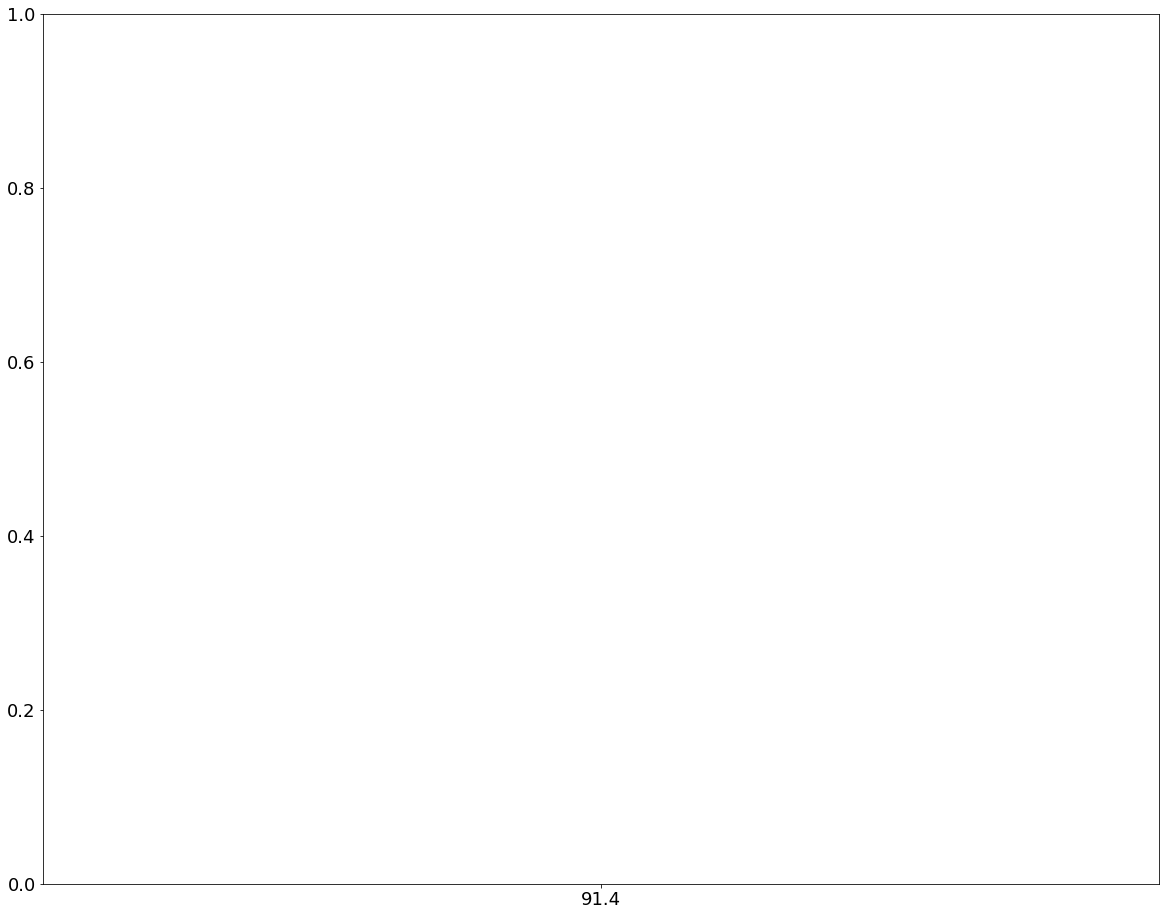

In [25]:
fig = plt.subplots(figsize=(20,16))
plt.hist(hs_17.high_school_4_year_graduation_rate_total, bins = 20, color='#99BDCB')
plt.title('HS 4 year graduation rate 2017')
plt.xlabel('Count of Schools')
plt.ylabel('Graduation Rate')
plt.tight_layout()
plt.savefig('figures/2017_hist.png')
plt.show();

#### Class of 2016

In [27]:
df_16 = pd.read_excel('../../data/2016-Report-Card-Public-Data-Set_clean.xlsx')
df_16.shape

(3735, 35)

In [28]:
clean_col(df_16)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [29]:
q4 = """SELECT * 
       FROM df_16
       WHERE grades_served LIKE "%12%";"""

hs_16 = pysqldf(q4)

In [30]:
hs_16.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2016,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,8.4,"$34,801",None,3,65,65,77.8,0,0,0
1,2016,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,16.7,"$40,883",None,1,77.3,70.5,97.9,,,
2,2016,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,13.7,"$46,882",None,2,76.7,70,94.3,0,0,0
3,2016,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,15.6,"$40,823",None,1,63.6,60,84.4,0,0,21
4,2016,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,26.4,"$44,780",None,2,62.2,57.1,,144,161,157


In [ ]:
list(hs_16.high_school_4_year_graduation_rate_total.values)

In [ ]:
fig = plt.subplots(figsize=(20,16))
plt.hist(hs_16.high_school_4_year_graduation_rate_total, bins = 20, color='#99BDCB')
plt.title('HS 4 year graduation rate 2016')
plt.xlabel('Count of Schools')
plt.ylabel('Graduation Rate')
plt.tight_layout()
plt.savefig('figures/2016_hist.png')
plt.show();

#### Class of 2015


In [31]:
df_15 = pd.read_excel('../../data/2015-Report-Card-Public-Data-Set_clean.xlsx')
df_15.shape

(3764, 35)

In [32]:
clean_col(df_15)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [33]:
q5 = """SELECT * 
       FROM df_15
       WHERE grades_served LIKE "%12%";"""

hs_15 = pysqldf(q5)

In [ ]:
hs_15.head()

In [ ]:
fig = plt.subplots(figsize=(20,16))
plt.hist(hs_15.high_school_4_year_graduation_rate_total, bins = 20, color='#99BDCB')
plt.title('HS 4 year graduation rate 2015')
plt.xlabel('Count of Schools')
plt.ylabel('Graduation Rate')
plt.tight_layout()
plt.savefig('figures/2015_hist.png')
plt.show();

#### Class of 2014

In [34]:
df_14 = pd.read_excel('../../data/2014-Report-Card-Public-Data-Set_clean.xlsx')
df_14.shape

(3794, 35)

In [35]:
clean_col(df_14)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [36]:
q6 = """SELECT * 
       FROM df_14
       WHERE grades_served LIKE "%12%";"""

hs_14 = pysqldf(q6)

In [ ]:
hs_14.head()

In [ ]:
fig = plt.subplots(figsize=(20,16))
plt.hist(hs_14.high_school_4_year_graduation_rate_total, bins = 20, color='#99BDCB')
plt.title('HS 4 year graduation rate 2014')
plt.xlabel('Count of Schools')
plt.ylabel('Graduation Rate')
plt.tight_layout()
plt.savefig('figures/2014_hist.png')
plt.show();

#### Class of 2013

In [37]:
df_13 = pd.read_excel('../../data/2013-Report-Card-Public-Data-Set_clean.xlsx')
df_13.shape

(3862, 35)

In [38]:
clean_col(df_13)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [39]:
q7 = """SELECT * 
       FROM df_13
       WHERE grades_served LIKE "%12%";"""

hs_13 = pysqldf(q7)

In [ ]:
hs_13.head()

### Step 2
create a matrix where one row is the cohort of a school (e.g. cohort 2018 for school xxx1, cohort 2017 for xxx1, cohort 2018 for school yyy2, cohort 2017 for school yyy2).

In [40]:
columns_check= list(hs_13.columns)

dataframes_check = [hs_14, hs_15, hs_16, hs_17, hs_18]
missing = {}
for idx, dataframe in enumerate(dataframes_check):
    missing_columns = [x for x in columns_check if x not in dataframes_check[idx].columns]
    if missing_columns:
        missing[idx]=missing_columns

In [41]:
missing

{}

In [42]:
final_features=['cohort','rcdts','school_name','district','city','county','district_type', 'district_size',
                'school_type','grades_served','percent_student_enrollment_white',
                'percent_student_enrollment_black_or_african_american',
                'percent_student_enrollment_hispanic_or_latino','percent_student_enrollment_asian',
                'percent_student_enrollment_native_hawaiian_or_other_pacific_islander','percent_student_enrollment_american_indian_or_alaska_native','percent_student_enrollment_two_or_more_races',
                'number_student_enrollment','total_number_of_school_days','student_attendance_rate','student_chronic_truancy_rate',
                'high_school_dropout_rate_total','high_school_4_year_graduation_rate_total','high_school_5_year_graduation_rate_total',
                'avg_class_size_high_school','pupil_teacher_ratio_high_school','teacher_retention_rate',
                'principal_turnover_within_6_years','percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months','percent_9th_grade_on_track',
                'number_students_who_took_ap_classes_grade_10_total','number_students_who_took_ap_classes_grade_11_total',
                'number_students_who_took_ap_classes_grade_12_total']
final_features
all_dfs=[hs_13, hs_14, hs_15, hs_16, hs_17]
filtered_dfs=[]

for dataframe in all_dfs:
    filtered_dfs.append(dataframe[final_features])
    
merged_df = pd.concat(all_dfs) 

### Step 3
EDA on merged set.
additional cleaning and sorting 

In [43]:
proj_eda(merged_df)

,null_sum,null_pct,dtypes,count,mean,median,min,max
avg_class_size_high_school,0,0.000000,object,3403,NaN,NaN,,9.9
city,0,0.000000,object,3403,NaN,NaN,Abingdon,Zion
cohort,0,0.000000,int64,3403,2015.020276,2015.0,2013,2017
county,0,0.000000,object,3403,NaN,NaN,Adams,Woodford
district,0,0.000000,object,3403,NaN,NaN,A-C Central CUSD 262,Zion-Benton Twp HSD 126
district_size,0,0.000000,object,3403,NaN,NaN,LARGE,SMALL
district_type,0,0.000000,object,3403,NaN,NaN,HIGH SCHOOL,UNIT
grades_served,0,0.000000,object,3403,NaN,NaN,10 11 12,PK K 1 2 3 4 5 6 7 8 9 10 11 12
high_school_4_year_graduation_rate_total,0,0.000000,object,3403,NaN,NaN,,99.7
high_school_5_year_graduation_rate_total,0,0.000000,object,3403,NaN,NaN,,99.8


In [44]:
list(merged_df.select_dtypes(['object', 'bool', 'category']))

['rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
 'percent_9th_grade_on_track',
 'number_students_who_took_ap_classes_grade_10_total',
 'number_students_who_took_ap_classes_grade_11_total',
 'number_students_who_took_ap_classes_grade_12_total']

Several of these need to be changed to floats

In [45]:
merged_df['total_number_of_school_days']= pd.to_numeric(merged_df['total_number_of_school_days'],downcast='float', errors='coerce')
merged_df['student_chronic_truancy_rate']= pd.to_numeric(merged_df['student_chronic_truancy_rate'],downcast='float', errors='coerce')
merged_df['high_school_dropout_rate_total']= pd.to_numeric(merged_df['high_school_dropout_rate_total'],downcast='float', errors='coerce')
merged_df['high_school_4_year_graduation_rate_total']= pd.to_numeric(merged_df['high_school_4_year_graduation_rate_total'],downcast='float', errors='coerce')
merged_df['high_school_5_year_graduation_rate_total']= pd.to_numeric(merged_df['high_school_5_year_graduation_rate_total'],downcast='float', errors='coerce')
merged_df['avg_class_size_high_school']= pd.to_numeric(merged_df['avg_class_size_high_school'],downcast='float', errors='coerce')
merged_df['pupil_teacher_ratio_high_school']= pd.to_numeric(merged_df['pupil_teacher_ratio_high_school'],downcast='float', errors='coerce')
merged_df['teacher_avg_salary']= pd.to_numeric(merged_df['teacher_avg_salary'],downcast='float', errors='coerce')
merged_df['teacher_retention_rate']= pd.to_numeric(merged_df['teacher_retention_rate'],downcast='float', errors='coerce')
merged_df['principal_turnover_within_6_years']= pd.to_numeric(merged_df['principal_turnover_within_6_years'],downcast='float', errors='coerce')
merged_df['percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months']= pd.to_numeric(merged_df['percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months'],downcast='float', errors='coerce')
merged_df['percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months']= pd.to_numeric(merged_df['percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months'],downcast='float', errors='coerce')
merged_df['percent_9th_grade_on_track']= pd.to_numeric(merged_df['percent_9th_grade_on_track'],downcast='float', errors='coerce')
merged_df['number_students_who_took_ap_classes_grade_10_total']= pd.to_numeric(merged_df['number_students_who_took_ap_classes_grade_10_total'],downcast='float', errors='coerce')
merged_df['number_students_who_took_ap_classes_grade_11_total']= pd.to_numeric(merged_df['number_students_who_took_ap_classes_grade_11_total'],downcast='float', errors='coerce')
merged_df['number_students_who_took_ap_classes_grade_12_total']= pd.to_numeric(merged_df['number_students_who_took_ap_classes_grade_12_total'],downcast='float', errors='coerce')




In [46]:
# check that again
list(merged_df.select_dtypes(['object', 'bool']))

['rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'student_attendance_rate']

Much better.

Now to check all the numericals are where they should be

In [47]:
# check that again
list(merged_df.select_dtypes(['float32', 'int64']))

['cohort',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months',
 'percent_9th_grade_on_track',
 'number_students_who_took_ap_classes_grade_10_total',
 'number_students_who_took_ap_classes_grade_11_total',
 'number_students_who_took_ap_classes_grade_12_total']

In [48]:
# cohort should be a category
merged_df['cohort'] = merged_df['cohort'].astype('category')
# check that again
list(merged_df.select_dtypes(['object', 'bool', 'category']))

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'student_attendance_rate']

In [51]:
cat_features= merged_df.select_dtypes(['object', 'bool', 'category'])

In [52]:
num_features = merged_df.select_dtypes(['float32', 'int64'])

In [53]:
num_features.isnull().sum()

number_student_enrollment                                                        0
total_number_of_school_days                                                    675
student_chronic_truancy_rate                                                     0
high_school_dropout_rate_total                                                   2
high_school_4_year_graduation_rate_total                                        19
high_school_5_year_graduation_rate_total                                        60
avg_class_size_high_school                                                      34
pupil_teacher_ratio_high_school                                                682
teacher_avg_salary                                                            3403
teacher_retention_rate                                                        1399
principal_turnover_within_6_years                                              753
percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months    1440
perc

In [54]:
num_features = num_features.drop(['teacher_avg_salary'], axis=1)

In [55]:
num_features.high_school_4_year_graduation_rate_total.sort_values(na_position='first')

348      NaN
411      NaN
182      NaN
412      NaN
163      NaN
       ...  
573    100.0
32     100.0
416    100.0
126    100.0
416    100.0
Name: high_school_4_year_graduation_rate_total, Length: 3403, dtype: float32

In [56]:
num_features.high_school_4_year_graduation_rate_total.fillna(num_features.high_school_4_year_graduation_rate_total.mean(), inplace=True)

In [57]:
num_features.high_school_4_year_graduation_rate_total.sort_values(ascending=False)

416    100.0
573    100.0
618    100.0
191    100.0
392    100.0
       ...  
413      0.0
227      0.0
290      0.0
300      0.0
213      0.0
Name: high_school_4_year_graduation_rate_total, Length: 3403, dtype: float32

In [58]:
num_features.high_school_4_year_graduation_rate_total.sort_values(na_position='first')

213      0.0
300      0.0
290      0.0
227      0.0
413      0.0
       ...  
392    100.0
191    100.0
618    100.0
573    100.0
416    100.0
Name: high_school_4_year_graduation_rate_total, Length: 3403, dtype: float32

In [59]:
num_features.total_number_of_school_days.fillna(num_features.total_number_of_school_days.mean(), inplace=True)
num_features.high_school_dropout_rate_total.fillna(num_features.high_school_dropout_rate_total.mean(), inplace=True)
num_features.high_school_5_year_graduation_rate_total.fillna(num_features.high_school_5_year_graduation_rate_total.mean(), inplace=True)
num_features.avg_class_size_high_school.fillna(num_features.avg_class_size_high_school.mean(), inplace=True)

In [60]:
proj_eda(num_features)

,null_sum,null_pct,dtypes,count,mean,median,min,max
number_student_enrollment,0,0.000000,int64,3403,929.945048,513.000000,18.0,11371.000000
total_number_of_school_days,0,0.000000,float32,3403,175.643097,175.643692,165.0,192.000000
student_chronic_truancy_rate,0,0.000000,float32,3403,15.153668,4.500000,0.0,100.000000
high_school_dropout_rate_total,0,0.000000,float32,3403,2.562809,1.300000,0.0,130.199997
high_school_4_year_graduation_rate_total,0,0.000000,float32,3403,85.282974,88.500000,0.0,100.000000
high_school_5_year_graduation_rate_total,0,0.000000,float32,3403,87.718521,90.099998,2.6,100.000000
avg_class_size_high_school,0,0.000000,float32,3403,17.466038,17.600000,0.3,81.000000
pupil_teacher_ratio_high_school,682,0.200411,float32,2721,17.216738,17.900000,5.0,33.799999
teacher_retention_rate,1399,0.411108,float32,2004,83.616920,87.099998,0.0,100.000000
principal_turnover_within_6_years,753,0.221275,float32,2650,2.250189,2.000000,1.0,61.000000


### Step 4 check correlations


In [61]:
merged_df.corr()['high_school_4_year_graduation_rate_total']

percent_student_enrollment_white                                              0.329463
percent_student_enrollment_black_or_african_american                         -0.344171
percent_student_enrollment_hispanic_or_latino                                -0.122394
percent_student_enrollment_asian                                              0.163616
percent_student_enrollment_native_hawaiian_or_other_pacific_islander          0.006630
percent_student_enrollment_american_indian_or_alaska_native                  -0.002513
percent_student_enrollment_two_or_more_races                                  0.001656
number_student_enrollment                                                     0.053115
total_number_of_school_days                                                  -0.116527
student_chronic_truancy_rate                                                 -0.468511
high_school_dropout_rate_total                                               -0.613447
high_school_4_year_graduation_rate_total   

In [62]:
num_features.corr()['high_school_4_year_graduation_rate_total']

number_student_enrollment                                                     0.052990
total_number_of_school_days                                                  -0.106300
student_chronic_truancy_rate                                                 -0.467969
high_school_dropout_rate_total                                               -0.611491
high_school_4_year_graduation_rate_total                                      1.000000
high_school_5_year_graduation_rate_total                                      0.713912
avg_class_size_high_school                                                    0.096593
pupil_teacher_ratio_high_school                                              -0.127544
teacher_retention_rate                                                        0.328622
principal_turnover_within_6_years                                            -0.186090
percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months    0.453825
percent_graduates_enrolled_in_a_postseconda

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


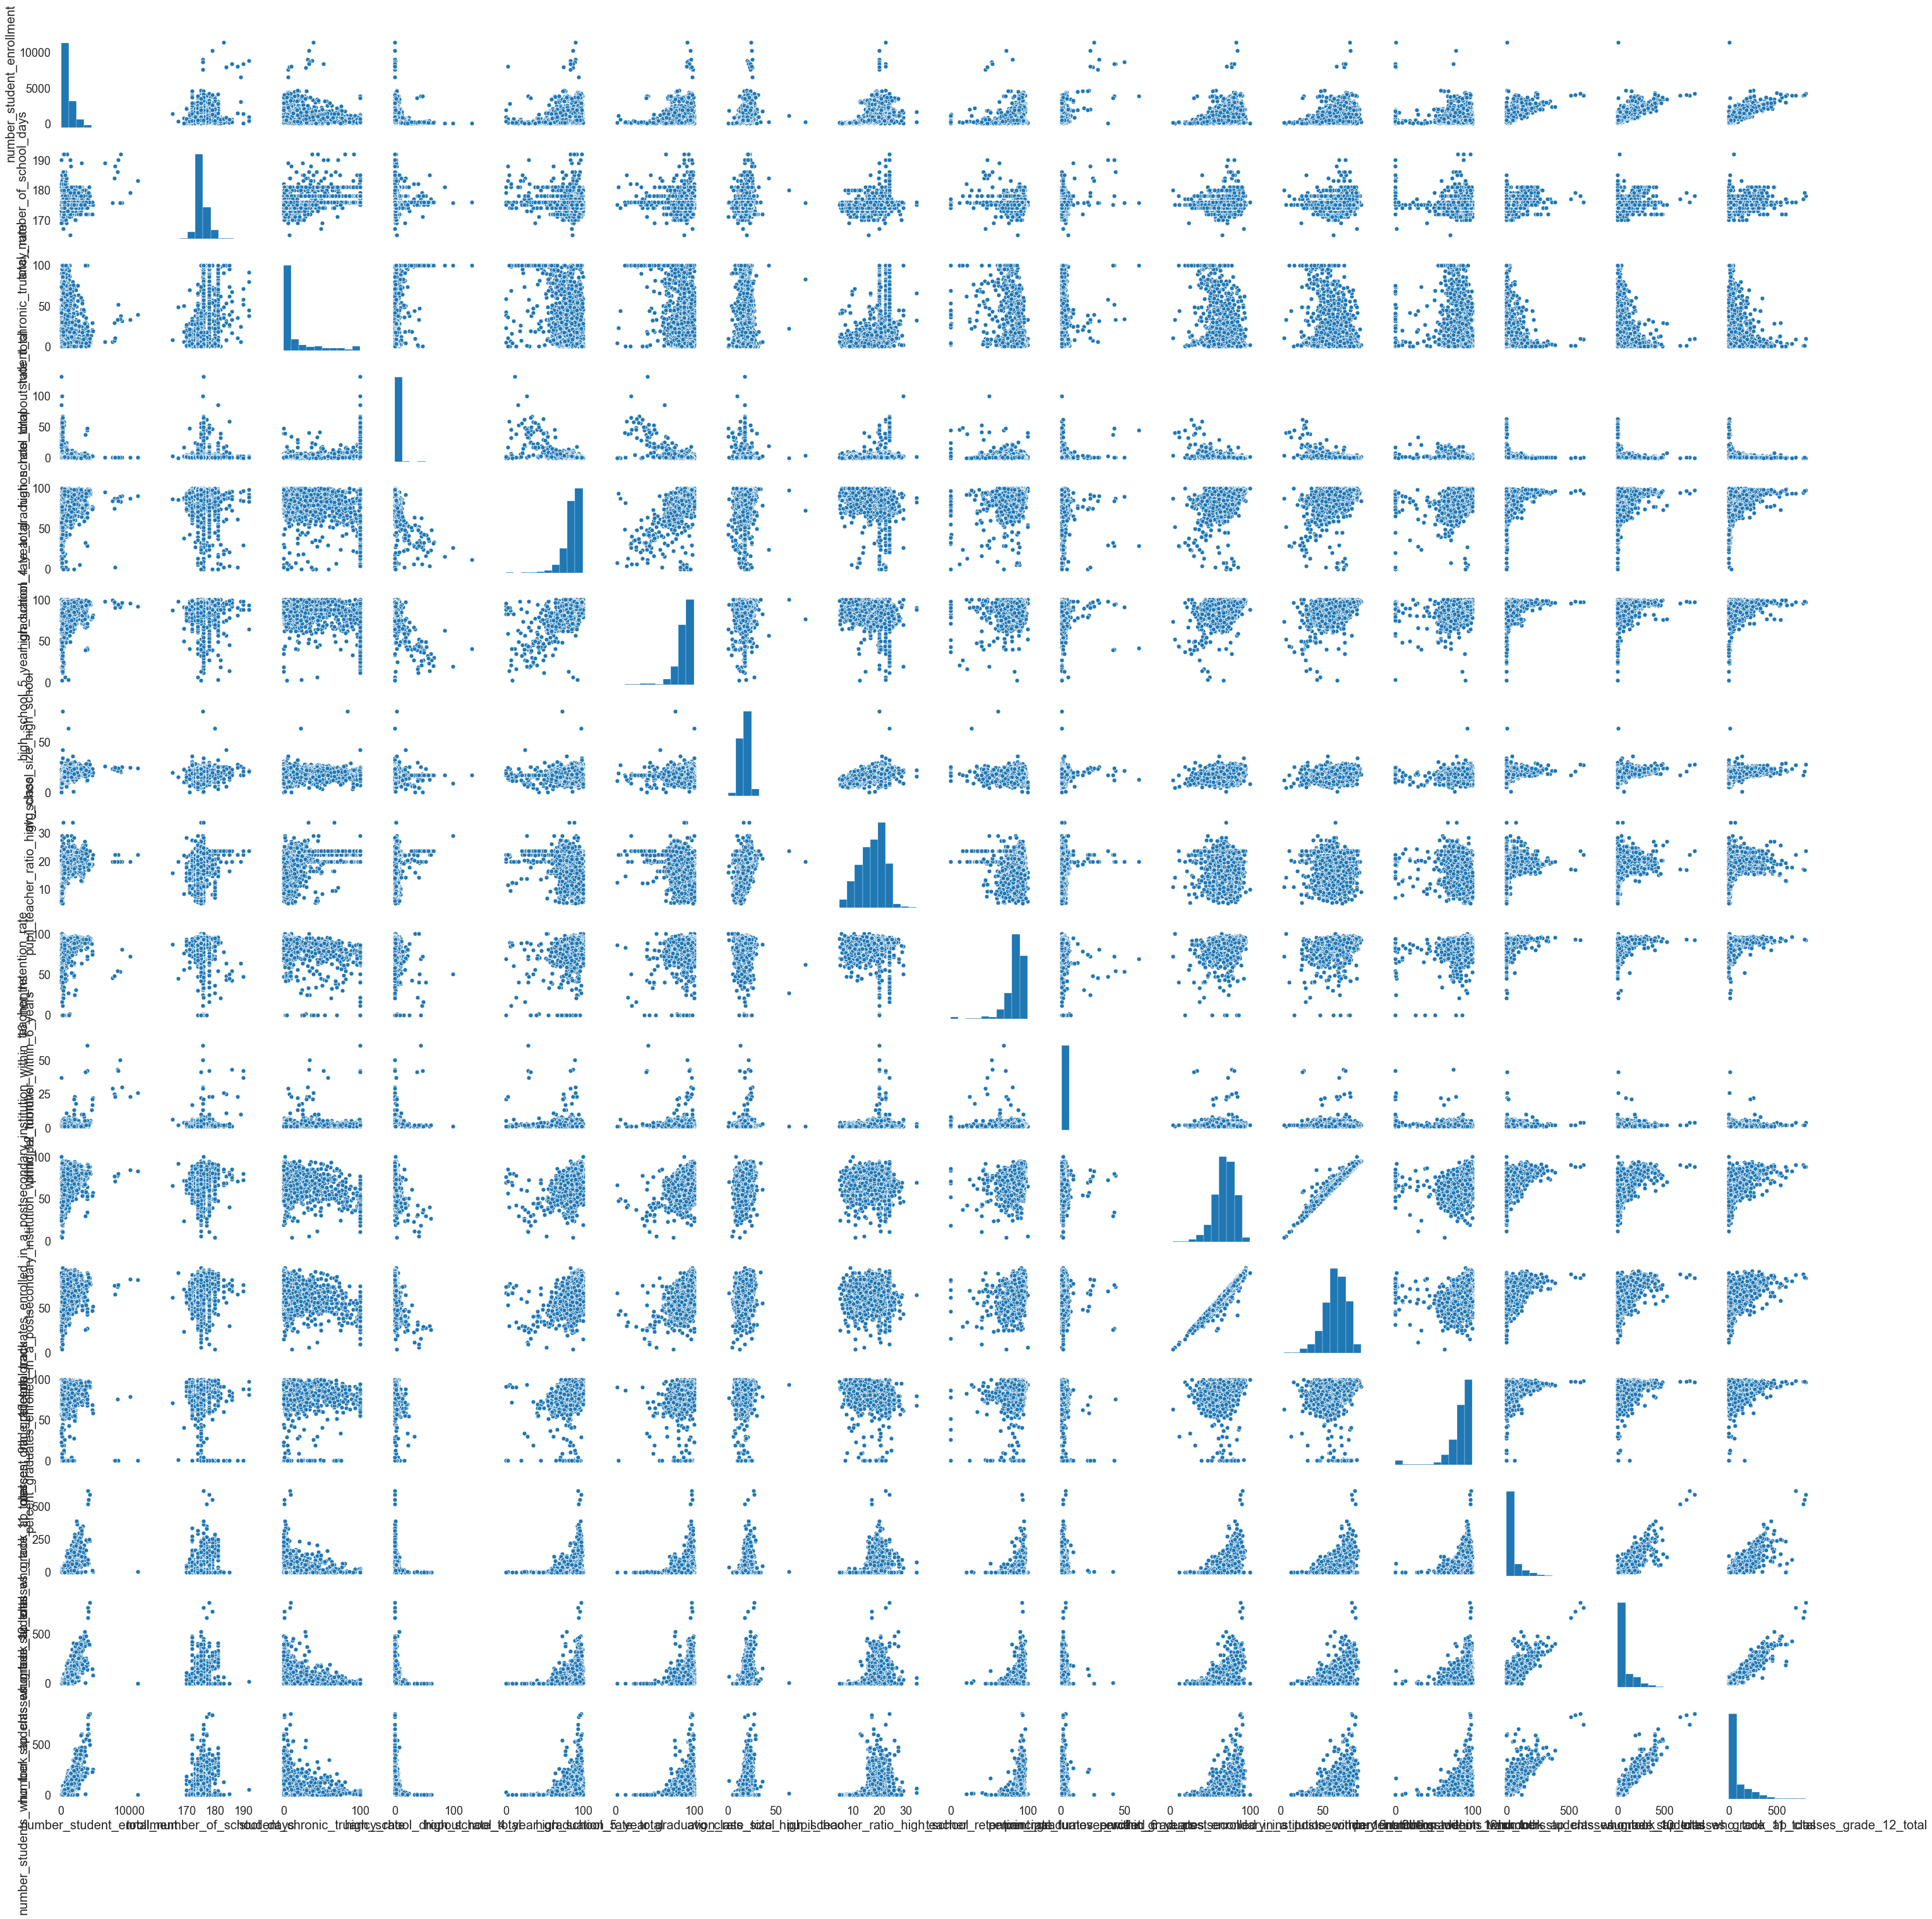

In [99]:
figsize=(20,20)
sns.pairplot(num_features);

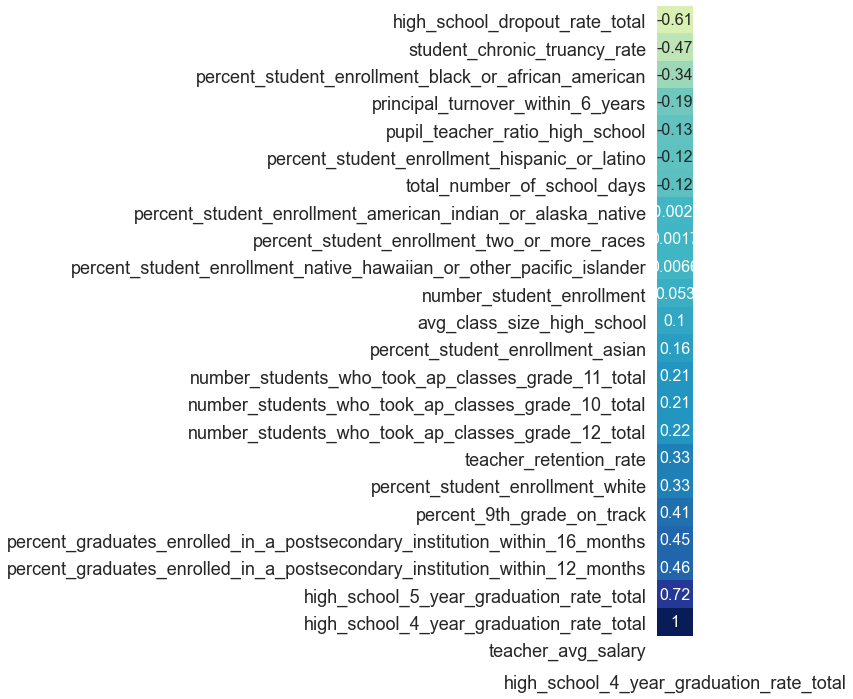

In [109]:
heatmap_numeric_w_dependent_variable(merged_df, 'high_school_4_year_graduation_rate_total')
figsize=(20,16)
plt.tight_layout()
plt.savefig('figures/heatmap1.png')
plt.show();

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


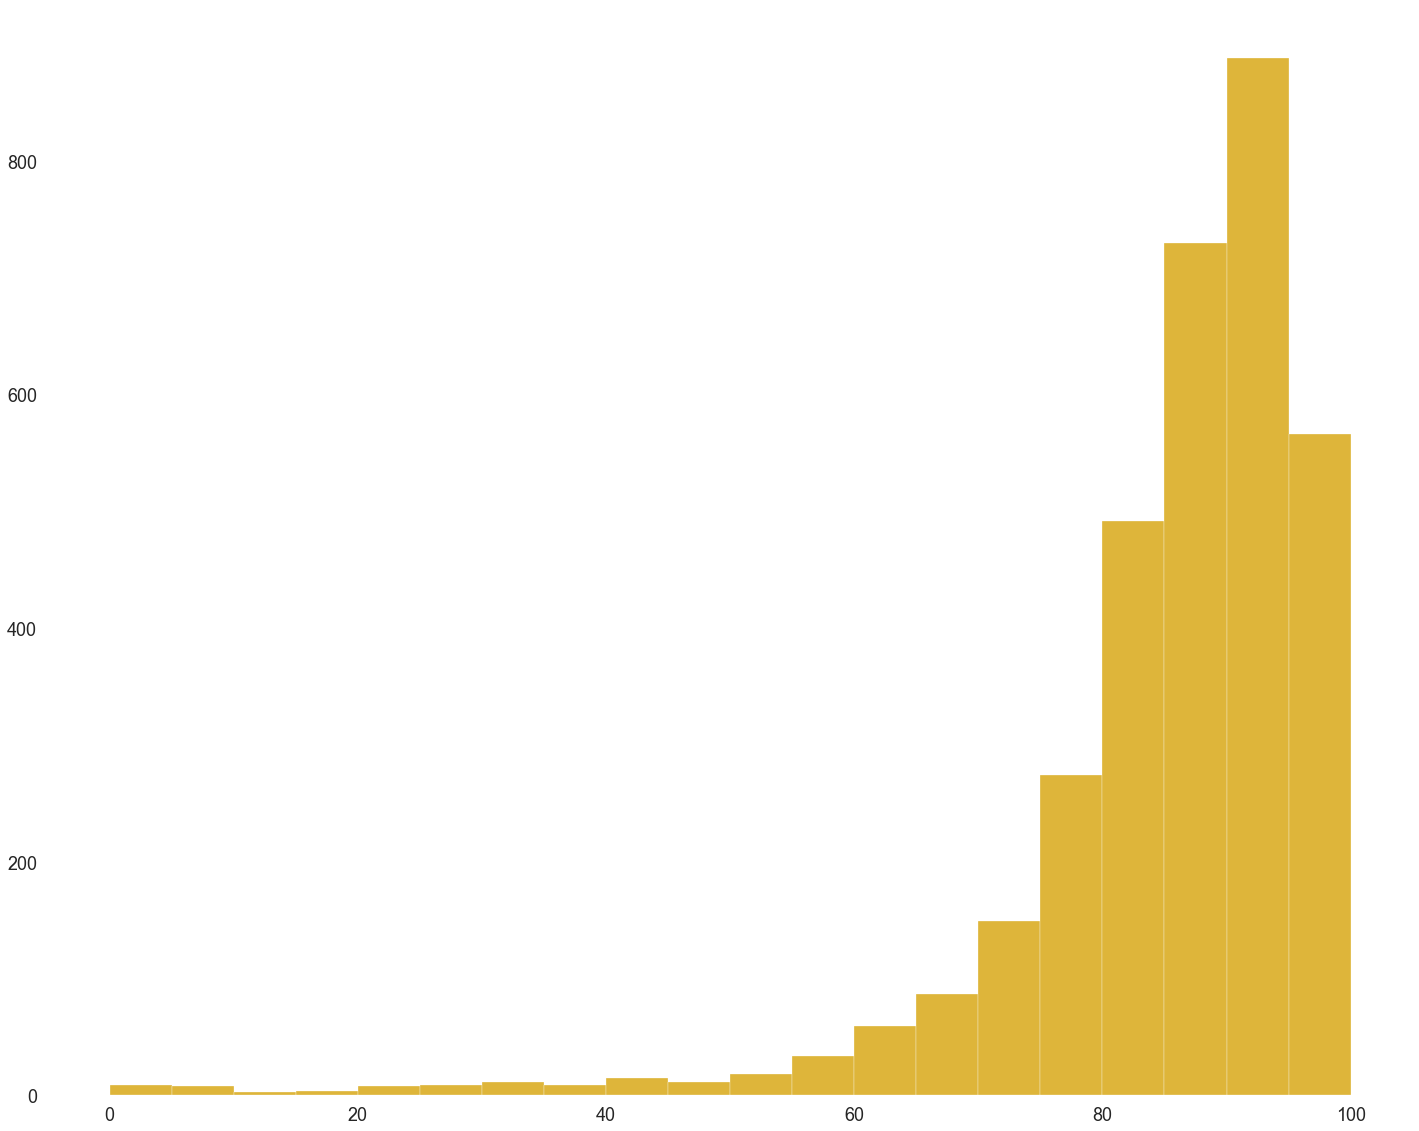

In [100]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16

fig = plt.subplots(figsize=(20,16))
plt.hist(merged_df.high_school_4_year_graduation_rate_total, bins = 20, color='#DEB53A')
#plt.title('HS 4 year graduation rate')
#plt.xlabel('Count of Schools')
#plt.ylabel('Graduation Rate')
plt.tight_layout()
plt.savefig('figures/merged_hist.png')
plt.show();

In [119]:
def bar(x, y, title, xlabel):
    fig = plt.subplots(figsize=(20,16))
    
    #for index, value in enumerate(x):
    #    plt.text(value, index, str(value))
    plt.bar(x, y, color='#DEB53A')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show();

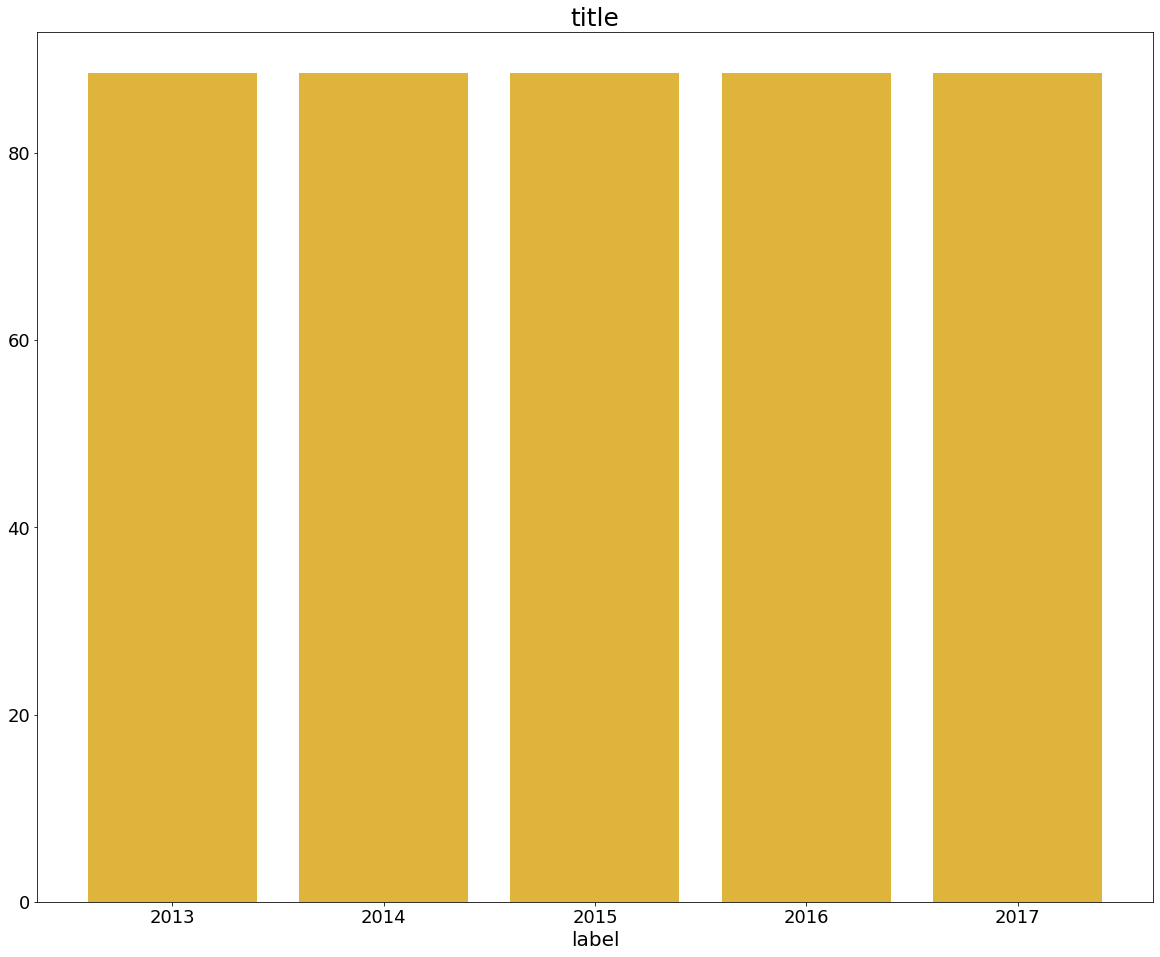

In [131]:
bar(merged_df.cohort, merged_df.high_school_4_year_graduation_rate_total.median(), 'title', 'label')

In [66]:
heatmap_numeric_w_dependent_variable(num_sm_features, 'high_school_4_year_graduation_rate_total')
plt.savefig('figures/heatmap.png')
plt.show();

NameError: name 'num_sm_features' is not defined

In [81]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [82]:
forward_selected_model = forward_selected(num_features, 'high_school_4_year_graduation_rate_total')

In [83]:
forward_selected_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     high_school_4_year_graduation_rate_total   R-squared:                       0.686
Model:                                                  OLS   Adj. R-squared:                  0.683
Method:                                       Least Squares   F-statistic:                     294.0
Date:                                      Fri, 07 Aug 2020   Prob (F-statistic):          2.47e-297
Time:                                              14:00:07   Log-Likelihood:                -4055.8
No. Observations:                                      1222   AIC:                             8132.
Df Residuals:                                          1212   BIC:                             8183.
Df Model:                                                 9                                         
Covariance Type:                                  nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                            -24.9716     20.498     -1.218      0.223     -65.186      15.243
high_school_5_year_graduation_rate_total               0.7304      0.027     27.093      0.000       0.678       0.783
number_students_who_took_ap_classes_grade_10_total    -0.0008      0.005     -0.160      0.873      -0.011       0.009
student_chronic_truancy_rate                          -0.0796      0.012     -6.475      0.000      -0.104      -0.055
high_school_dropout_rate_total                        -0.2556      0.051     -5.006      0.000      -0.356      -0.155
avg_class_size_high_school                             0.1844      0.057      3.221      0.001       0.072       0.297
number_student_enrollment                             -0.0013      0.000     -3.361      0.001      -0.002      -0.001
number_students_who_took_ap_classes_grade_12_total     0.0080      0.004      2.062      0.039       0.000       0.016
total_number_of_school_days                            0.2660      0.119      2.235      0.026       0.032       0.500
pupil_teacher_ratio_high_school                       -0.0179      0.062     -0.288      0.774      -0.140       0.104
==============================================================================
Omnibus:                     1213.704   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           175799.005
Skew:                          -4.243   Prob(JB):                         0.00
Kurtosis:                      61.144   Cond. No.                     1.45e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Step 5 FSM
Linear Regression

In [70]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [71]:
X = num_features.drop("high_school_4_year_graduation_rate_total", axis=1)
y = num_features["high_school_4_year_graduation_rate_total"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
test=pd.DataFrame(X_train)
test.info()

num_sm_features = num_features[['high_school_4_year_graduation_rate_total', 
                                'number_student_enrollment', 
                                'total_number_of_school_days', 
                                'student_chronic_truancy_rate',
                                'high_school_dropout_rate_total', 
                                'high_school_5_year_graduation_rate_total', 
                                'avg_class_size_high_school']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 347 to 483
Data columns (total 15 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   number_student_enrollment                                                   2552 non-null   int64  
 1   total_number_of_school_days                                                 2552 non-null   float32
 2   student_chronic_truancy_rate                                                2552 non-null   float32
 3   high_school_dropout_rate_total                                              2552 non-null   float32
 4   high_school_5_year_graduation_rate_total                                    2552 non-null   float32
 5   avg_class_size_high_school                                                  2552 non-null   float32
 6   pupil_teacher_ratio_high_school                

In [72]:
X = num_sm_features.drop("high_school_4_year_graduation_rate_total", axis=1)
y = num_sm_features["high_school_4_year_graduation_rate_total"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [73]:
lin_reg_model = LinearRegression()
baseline_cross_val_score = cross_val_score(lin_reg_model, X_train, y_train)
baseline_cross_val_score

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.50760721, 0.55990322, 0.62449543])

In [74]:
outcome = 'high_school_4_year_graduation_rate_total'
predictors = num_sm_features.drop('high_school_4_year_graduation_rate_total', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=num_features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     high_school_4_year_graduation_rate_total   R-squared:                       0.578
Model:                                                  OLS   Adj. R-squared:                  0.577
Method:                                       Least Squares   F-statistic:                     775.7
Date:                                      Fri, 07 Aug 2020   Prob (F-statistic):               0.00
Time:                                              13:59:01   Log-Likelihood:                -12121.
No. Observations:                                      3403   AIC:                         2.426e+04
Df Residuals:                                          3396   BIC:                         2.430e+04
Df Model:                                                 6                                         
Covariance Type:                                  nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   72.2031     13.310      5.425      0.000      46.107      98.299
number_student_enrollment                   -0.0006      0.000     -3.337      0.001      -0.001      -0.000
total_number_of_school_days                 -0.2431      0.077     -3.158      0.002      -0.394      -0.092
student_chronic_truancy_rate                -0.0951      0.008    -12.323      0.000      -0.110      -0.080
high_school_dropout_rate_total              -0.3950      0.033    -12.101      0.000      -0.459      -0.331
high_school_5_year_graduation_rate_total     0.6352      0.018     34.734      0.000       0.599       0.671
avg_class_size_high_school                   0.1747      0.037      4.767      0.000       0.103       0.247
==============================================================================
Omnibus:                     2832.792   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           169743.426
Skew:                          -3.562   Prob(JB):                         0.00
Kurtosis:                      36.858   Cond. No.                     1.25e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [89]:
from sklearn.ensemble import RandomForestRegressor

rfr= RandomForestRegressor(random_state=42)

print(rfr.fit(X_train, y_train))
print(cross_val_score(rfr, X_train, y_train))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
[0.50272678 0.59095471 0.62656666]


In [76]:
rfr.predict(X_test)

array([33.36999958, 89.77999954, 93.30999985, 92.11999893, 94.49999924,
       95.37000122, 93.89999924, 93.62999878, 95.14999847, 86.51000061,
       97.59000015, 94.66999969, 84.88000031, 87.17999954, 87.90999985,
       80.68999939, 91.07999954, 93.2       , 77.9       , 88.29000015,
       83.98000107, 89.25      , 73.21000061, 84.22999878, 78.35999908,
       88.93000031, 92.67000046, 82.99999924, 91.88999939, 62.67999992,
       82.69999847, 89.25999908, 90.75      , 96.        , 44.69999962,
       89.51999969, 30.97000027, 85.8       , 95.27000046, 45.03999901,
       81.32829895, 88.6       , 88.98000031, 96.36000061, 88.06000137,
       87.42000122, 93.09999924, 49.22000027, 82.23000107, 82.97829819,
       60.42000008, 91.15      , 84.15999985, 95.87999878, 92.07000046,
       84.62999954, 80.27999954, 93.76999969, 79.07999954, 96.44999924,
       81.34829941, 88.04999924, 81.86999893, 79.83999863, 88.68999939,
       85.38000031, 64.14999886, 85.97999954, 94.37999954, 95.6 

In [77]:
cross_val_score(rfr, X_train, y_train)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.50272678, 0.59095471, 0.62656666])